In [1]:
#imports
import pandas as pd
import numpy as np

#!pip install imbalanced-learn
#!pip install nltk
#!pip install langdetect

import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

from copy import deepcopy

# integrating our preprocessing into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer as wn
from nltk.corpus import wordnet
from nltk import pos_tag

from langdetect import detect_langs
import string # 
import re # regex
import itertools # flattening

nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# tensorflow?

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Viki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Viki/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Viki/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Viki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Viki/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
### Data Exploration

In [3]:
df = pd.read_csv('data/all.csv')
#df['comment_text'].iloc[0]
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d787bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312732 entries, 0 to 312731
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             312732 non-null  object
 1   comment_text   312731 non-null  object
 2   toxic          312732 non-null  int64 
 3   severe_toxic   312732 non-null  int64 
 4   obscene        312732 non-null  int64 
 5   threat         312732 non-null  int64 
 6   insult         312732 non-null  int64 
 7   identity_hate  312732 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 19.1+ MB


In [5]:
df.isna().sum()

id               0
comment_text     1
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
df.dropna(inplace = True)

In [7]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
# inspecting toxic comments
toxic = df.loc[df['toxic'] == 1]
toxic.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
312727,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",1,1,1,1,1,1
312728,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,1,1,1,1,1,1
312729,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",1,1,1,1,1,1
312730,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",1,1,1,1,1,1
312731,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel...",1,1,1,1,1,1


In [9]:
# inspecting a selected comment
print(df.iloc[12]['comment_text'])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [10]:
# checking the toxicity for the selected comment
print(df.iloc[12][df.columns[2:]])

toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 12, dtype: object


In [11]:
# checking value_counts for each column
values = df.iloc[:,2:].sum()
values

toxic            110569
severe_toxic      91147
obscene          101325
threat            89874
insult           100489
identity_hate     91302
dtype: int64

In [12]:
# toxic = df[df['toxic'] == 1]
# len(toxic)

In [13]:
# toxic = df[df['toxic'] == 0]
# len(toxic)

In [14]:
# sever = df[df['severe_toxic'] == 1] 
# len(sever)

In [15]:
# obscene = df[df['obscene'] == 1]
# len(obscene)

In [16]:
# threat = df[df['threat'] == 1]
# len(threat)/len(df)

In [17]:
# insult = df[df['insult'] == 1]
# len(insult)

In [18]:
# hate = df[df['identity_hate'] == 1]
# len(hate)

In [19]:
# not_threat = df[df['threat'] == 0]
# len(not_threat)/len(df)

In [20]:
# threat.head()

### Preprocessing

In [21]:
# stopword1 = stopwords.words('english')
#     # adding punctuations to stopwords
# stopword1 += list(string.punctuation) 

In [22]:
df['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
312727    . \n i totally agree, this stuff is nothing bu...
312728    == Throw from out field to home plate. == \n\n...
312729    " \n\n == Okinotorishima categories == \n\n I ...
312730    " \n\n == ""One of the founding nations of the...
312731    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 312731, dtype: object

### Modeling

In [23]:
words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá']

In [24]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        #define attributes to store if text preprocessing requires fitting from data
        
        pass
    
    def fit(self, data, y = 0):
        # this is where you would fit things like corpus specific stopwords
        # fit probable bigrams with bigram model in here
         stop_words = stopwords.words('english')
# #         # adding punctuations to stopwords
         stop_words += list(string.punctuation) 
         stop_words += words
        
        # save as parameters of Text preprocessor
        
         return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
        
    
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = wn()
        words = ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaa', 'aaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaa'\
        'ƒüesareviƒá']
        stop_words = stopwords.words('english')
        # adding punctuations to stopwords
        stop_words += list(string.punctuation) 
        stop_words += words
        
        # helper function to change nltk's part of speech tagging to a wordnet format.
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

            
      # remove stop words and punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()) & (tok not in stop_words))]
        doc_norm = [tok.lower() for tok in doc_norm]
        #doc_norm = [tok for tok in doc_norm if tok not in stop_words]
        
        #remove mentions, hashtags, and urls, strip whitspace and breaks
        #doc_norm = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", doc_norm).strip().replace("\r", "").replace("\n", "").replace("\t", "")
        
        doc_norm = [tok for tok in doc_norm if (tok not in stop_words) & ((len(tok)>2) & (len(tok)< 20))]
        
        # selecting english words only
        #doc_norm = [tok for tok in doc_norm if detect_langs(tok)[0].lang == 'en']
        
        doc_norm = [tok for tok in doc_norm if (len(tok)>2)]
        doc_norm = [tok for tok in doc_norm if (len(tok)< 15)]
        #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

In [25]:
# for word in words:
#     languages = detect_langs(word)
#     if languages[0].lang == "en":
#         filtered_words.append(word)
        
# filtered_words = [word for word in words if detect_langs(word)[0].lang == "en"]

In [26]:
#targets= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
X = df['comment_text']
y = df['toxic']

In [27]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
312727    . \n i totally agree, this stuff is nothing bu...
312728    == Throw from out field to home plate. == \n\n...
312729    " \n\n == Okinotorishima categories == \n\n I ...
312730    " \n\n == ""One of the founding nations of the...
312731    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 312731, dtype: object

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [29]:
proc = TextPreprocessor()

X_train_proc =proc.fit_transform(X_train)
#X_val_proc = proc.fit_transform(X_val)
X_test_proc = proc.transform(X_test)

In [30]:
#X_train_proc[39277]#.tail()

In [31]:
#count vectorizer
prc_steps = [('countvec', CountVectorizer())]
preprocess_pipeline = Pipeline(prc_steps)

In [32]:
preprocess_pipeline

Pipeline(steps=[('countvec', CountVectorizer())])

In [33]:
X_tr_proc = preprocess_pipeline.fit_transform(X_train_proc)

In [34]:
X_train_proc

114908                             portfolio shuffle around
286351                                       ciara clitoris
276118    copyright variant checker variant page exactly...
39466     happy discus future reference clear cite suppo...
178751    admins execute action base community consensus...
                                ...                        
21657     spaceman post comical admin low level debate s...
266688    intentionally grammar ever learn none post ben...
46775                   user ferret harassing follow around
199233    edits remain article article fuckin glow contr...
90191     try say early vanniyar know pallis cease accep...
Name: comment_text, Length: 250184, dtype: object

In [35]:
# freqDist

In [36]:
feature_names = preprocess_pipeline[
     'countvec'].get_feature_names_out()

new_df = pd.DataFrame(X_tr_proc.toarray(), columns = feature_names)

In [37]:
new_df.iloc[:,0:]

,aa,aaa,aaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaah,aaaaaaaaaah,aaaaaaaaah,aaaaaaw,aaaaah,aaaaanup,...,ƒëorƒëeviƒáa,ƒëur,ƒëyes,ƒúan,ƒúano,ƒüelap,ƒüirila,ƒüirilicom,ƒüp,ƒüuna
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# checking the original imbalance
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

0    0.64644
1    0.35356
Name: toxic, dtype: float64

### Model1 - MultinomialNB

In [39]:
pipe = deepcopy(preprocess_pipeline)
pipe.steps.append(('multinb', MultinomialNB()))
pipe.steps

[('countvec', CountVectorizer()), ('multinb', MultinomialNB())]

In [40]:
pipe.fit(X_train_proc, y_train)

Pipeline(steps=[('countvec', CountVectorizer()), ('multinb', MultinomialNB())])

In [41]:
transformed_test = proc.transform(X_test)

y_pred = pipe.predict(transformed_test) # automatically applies transforms and predicts on test

In [42]:
recall_score(y_test, y_pred)

0.4310843809351542

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.92      0.82     40433
           1       0.74      0.43      0.54     22114

    accuracy                           0.74     62547
   macro avg       0.74      0.67      0.68     62547
weighted avg       0.74      0.74      0.72     62547



In [44]:
roc_auc_score(y_test, y_pred)

0.6731016097538038

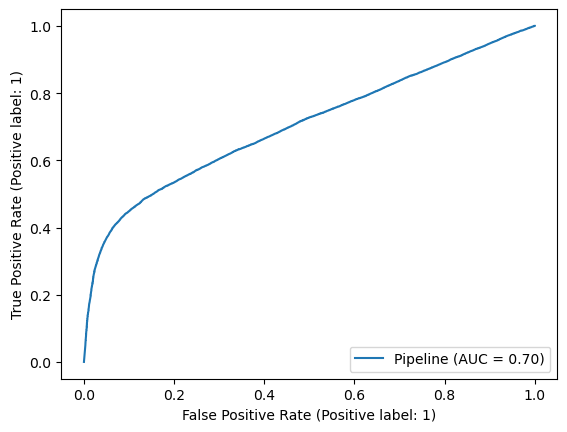

In [45]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe, X_test_proc, y_test) # changed transformed_test to X_test_proc

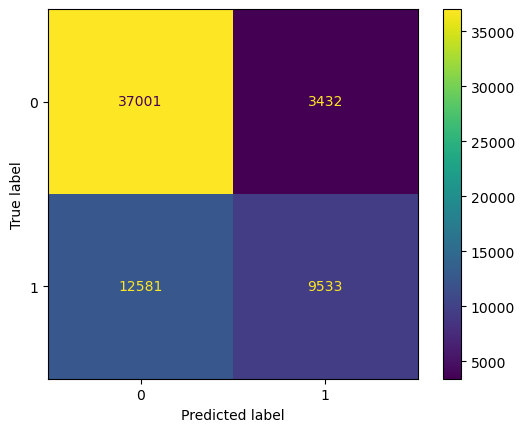

In [46]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe, X_test_proc, y_test);

### Model2

In [47]:
### Model 2 - try tf-idf vectorizer
TfidfVectorizer??
# model running slow - decrease min_df
# accuracy is not good - increase 

In [48]:
#count vectorizer
# prc_steps = [('tfidf', TfidfVectorizer(min_df = 0.05, max_df = 0.95))]
# preprocess_pipeline = Pipeline([prc_steps,
#                               ('smote', SMOTE(random_state= 40))])

In [49]:
pipe1 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                 ('smote', SMOTE()), 
                 ('multinb', MultinomialNB())])

In [50]:
pipe1.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('smote', SMOTE()), ('multinb', MultinomialNB())])

In [51]:
pipe1.score(X_train_proc, y_train)
pipe1.score(X_test_proc,y_test)

0.5457975602347035

In [52]:
y_pred = pipe1.predict(X_test_proc)


In [53]:
acc = accuracy_score(y_test, y_pred, normalize= True)
acc

0.5457975602347035

In [54]:
rec = recall_score(y_test, y_pred)
rec

0.3906122818124265

In [55]:
y_train.value_counts(normalize=True)

0    0.64644
1    0.35356
Name: toxic, dtype: float64

In [56]:
# try SMOTE to address the imbalance
# mod2_pipe = deepcopy(preprocess_pipeline)
# mod2_pipe.steps.append(('multinb', MultinomialNB()))
# mod2_pipe

In [57]:
# mod2_pipe.fit(X_train_proc, y_train)

In [58]:
# transformed_test = proc.transform(X_test)

# y_pred = pipe.predict(transformed_test)

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64     40433
           1       0.37      0.39      0.38     22114

    accuracy                           0.55     62547
   macro avg       0.51      0.51      0.51     62547
weighted avg       0.55      0.55      0.55     62547



In [60]:
roc_auc_score(y_test, y_pred)

0.5106426234823268

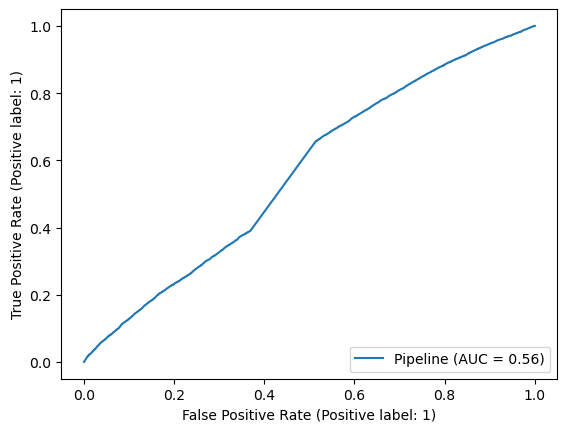

In [61]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

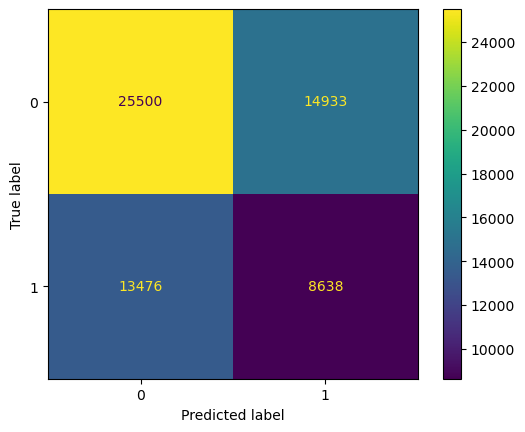

In [62]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe1, X_test_proc, y_test);

Appying SMOTE on the Multinomial Naive Bayes model did improve the number of false negatives from 26590 to 11650, that is more then 14k decrease. The AUC also increased from 50% to

### Model3 - RandomForest - SMOTE

In [134]:
# changing the Multinomial Naive Bayes to Random Forest

pipe1.steps.pop(-1)
pipe1.steps.append(['forest', RandomForestClassifier(random_state = 40)])

In [135]:
pipe1.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('smote', SMOTE()),
                ['forest', RandomForestClassifier(random_state=40)]])

In [136]:
pipe1.score(X_train_proc, y_train)
pipe1.score(X_test_proc,y_test)

0.5981741730218876

In [139]:
y_pred = pipe1.predict(X_test_proc)


In [140]:
acc = accuracy_score(y_test, y_pred, normalize= True)

In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67     40433
           1       0.44      0.53      0.48     22114

    accuracy                           0.60     62547
   macro avg       0.58      0.58      0.58     62547
weighted avg       0.62      0.60      0.60     62547



In [143]:
roc_auc_score(y_test, y_pred)

0.5833918751778436

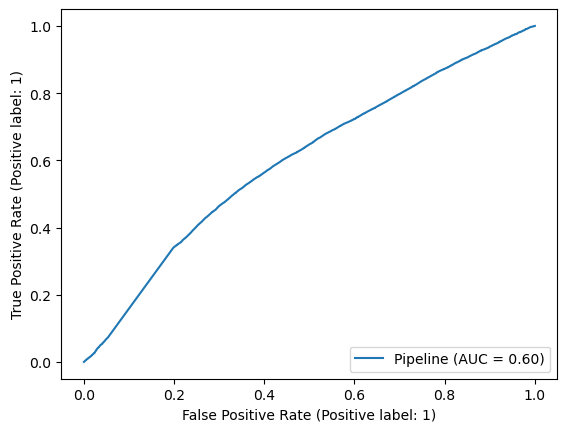

In [144]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe1, X_test_proc, y_test)

to Optimize the hyperparameters for the randomForest I will run a gridSearchCv to get the best parameters 

In [145]:
# Performing a grid search for our random forest
import time

start = time.time()

rf_params = param_grid = {'forest__criterion': ['gini', 'entropy'], 
                          'forest__n_estimators': [30, 50, 150], 
                          'forest__min_samples_leaf': [2, 5, 20, 50],
                         'forest__max_depth': [3, 5, 7]}

rf_grid_pipe = GridSearchCV(estimator = pipe1, param_grid = rf_params, scoring = 'recall', cv = 3, n_jobs = -1)

end = time.time()

print(end - start)
# try accuracy insted of recall

0.016754150390625


In [72]:
# try random search - grid search is too slow
# rf_random = RandomizedSearchCV(rf, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=3)
# model_random = rf_random.fit(X,y)

In [146]:
# Fitting the training data
start = time.time()

rf_grid_pipe.fit(X_train_proc, y_train)

end = time.time()
print(end - start)

1519.4174971580505


In [148]:
# Returning the best parameters as a result of the grid search
start = time.time()

rf_grid_pipe.best_params_

end = time.time()
print(end - start)

2.09808349609375e-05


In [149]:
rf_grid_pipe.best_params_

{'forest__criterion': 'entropy',
 'forest__max_depth': 3,
 'forest__min_samples_leaf': 2,
 'forest__n_estimators': 30}

In [76]:
# {'forest__criterion': 'gini',
#  'forest__max_depth': 3,
#  'forest__min_samples_leaf': 2,
#  'forest__n_estimators': 30}

In [77]:
# creating a model with the best parameters

In [150]:
pipe3 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                 ('smote', SMOTE()), 
                 ('forest', RandomForestClassifier(random_state = 43,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 2,
                                                  n_estimators = 30))])

In [151]:
# Fitting the model with the best params
pipe3.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('smote', SMOTE()),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=2,
                                        n_estimators=30, random_state=43))])

In [128]:
pipe3.score(X_train_proc, y_train)
pipe3.score(X_test_proc,y_test)

0.5398180568212704

In [152]:
y_pred = pipe3.predict(X_test_proc)

In [153]:
acc = accuracy_score(y_test, y_pred, normalize= True)


In [154]:
print(classification_report(y_test, y_pred)) # leaf - 20

              precision    recall  f1-score   support

           0       0.73      0.46      0.56     40433
           1       0.41      0.69      0.52     22114

    accuracy                           0.54     62547
   macro avg       0.57      0.58      0.54     62547
weighted avg       0.62      0.54      0.55     62547



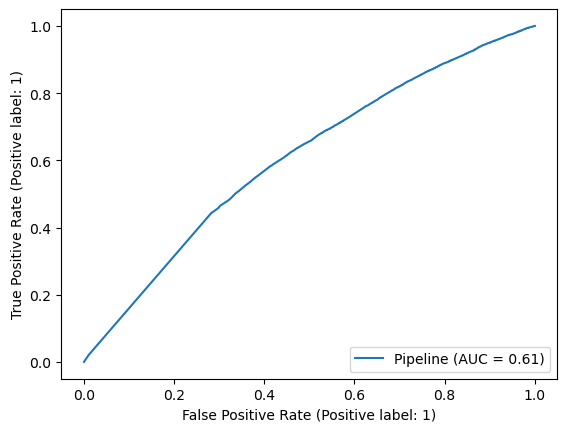

In [155]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe3, X_test_proc, y_test)

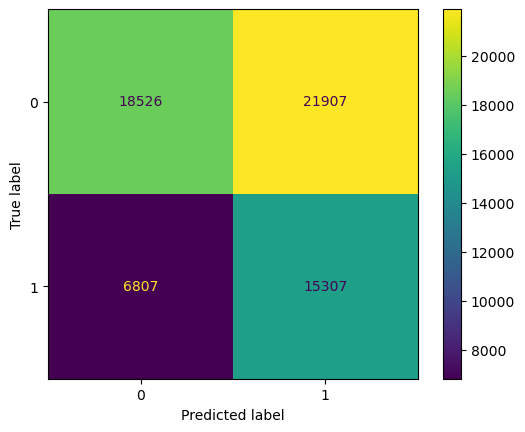

In [156]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe3, X_test_proc, y_test);

### Model4 - RandomForest - RandomOverSampler


In [86]:
#('over',RandomOverSampler(random_state=42, sampling_strategy='minority'))

In [157]:
pipe4 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                 ('over',RandomOverSampler(random_state=46)), 
                 ('forest', RandomForestClassifier(random_state = 46,
                                                  criterion = 'gini',
                                                  max_depth = 3,
                                                  min_samples_leaf = 20,
                                                  n_estimators = 30))])

In [158]:
pipe4.fit(X_train_proc,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('over', RandomOverSampler(random_state=46)),
                ('forest',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=20,
                                        n_estimators=30, random_state=46))])

In [159]:
pipe4.score(X_train_proc, y_train)
pipe4.score(X_test_proc,y_test)

0.5540153804339137

In [160]:
y_pred4 = pipe4.predict(X_test_proc)

In [161]:
acc = accuracy_score(y_test, y_pred4, normalize= True)

In [162]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.73      0.50      0.59     40433
           1       0.42      0.66      0.51     22114

    accuracy                           0.55     62547
   macro avg       0.57      0.58      0.55     62547
weighted avg       0.62      0.55      0.56     62547



In [163]:
roc_auc_score(y_test, y_pred4)

0.5783499819795741

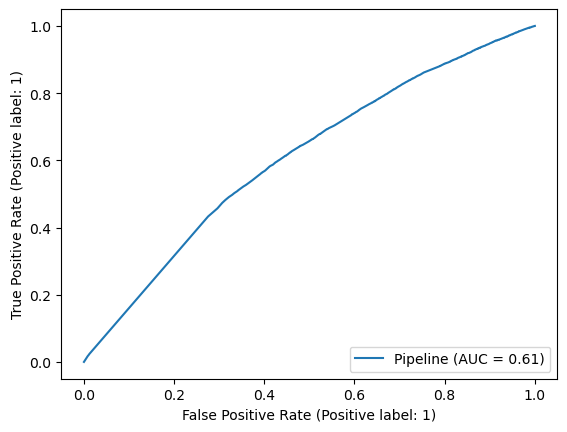

In [164]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe4, X_test_proc, y_test)

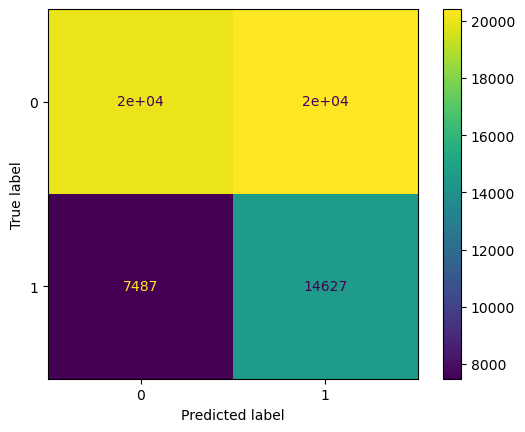

In [165]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe4, X_test_proc, y_test);

### Model5 - XGBoost


In [166]:
pipe5 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                   ('over', RandomOverSampler(random_state = 50)),
                   ('xgb', XGBClassifier(random_state = 50))])

In [167]:
# Performing a grid search for our XGBoost
xgb_params = {
    'xgb__gamma': [0.5, 1, 5],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__max_depth': [3, 5, 7],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__n_estimators': [50, 100, 150, 200],
}

xgb_grid = GridSearchCV(estimator = pipe5, param_grid = xgb_params, scoring = 'recall', cv = 3)

In [168]:
# Fitting the training data
xgb_grid.fit(X_train_proc, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.95,
                                                        min_df=0.05)),
                                       ('over',
                                        RandomOverSampler(random_state=50)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      featu...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=50, ...))]),
             param_grid={'xgb__gamma': [0.5, 1, 5],
                         'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__min_child_weight': [1, 5, 10],
                         'xgb__n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [169]:
# Returning the best parameters as a result of the grid search
xgb_grid.best_params_

{'xgb__gamma': 5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 10,
 'xgb__n_estimators': 50}

In [100]:
# {'xgb__gamma': 5,
#  'xgb__learning_rate': 0.1,
#  'xgb__max_depth': 3,
#  'xgb__min_child_weight': 10,
#  'xgb__n_estimators': 50}

In [170]:
# Creating a new pipeline that implements the best parameters
pipe6 = Pipeline(steps = ([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                           ('over', RandomOverSampler(random_state = 51)),
                           ('xgb', XGBClassifier(random_state = 51,
                                                 gamma = 5,
                                                 learning_rate = 0.1,
                                                 max_depth = 3,
                                                 min_child_weight = 10,
                                                 n_estimators = 50))]))

In [171]:
# Fitting the training data with the updated pipeline
pipe6.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('over', RandomOverSampler(random_state=51)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=5, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=3, max_leaves=0, min_child_weight=10,
                               missing=nan, monotone_constraints='()',
                               n_estimators=50, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=51, ...))])

In [172]:
y_pred6 = pipe6.predict(X_test_proc)

In [173]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.78      0.17      0.28     40433
           1       0.37      0.91      0.53     22114

    accuracy                           0.43     62547
   macro avg       0.57      0.54      0.40     62547
weighted avg       0.63      0.43      0.37     62547



In [174]:
roc_auc_score(y_test, y_pred)

0.5751880189031154

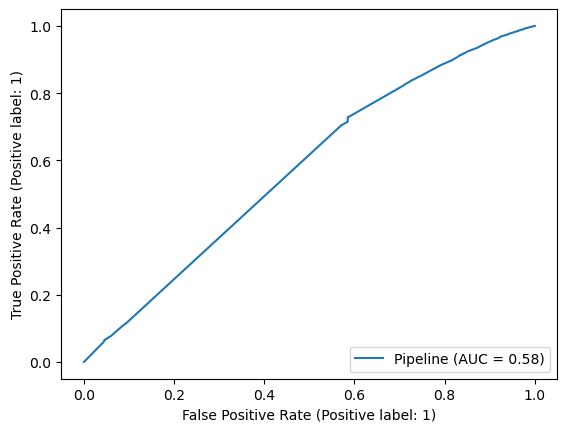

In [175]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe6, X_test_proc, y_test)

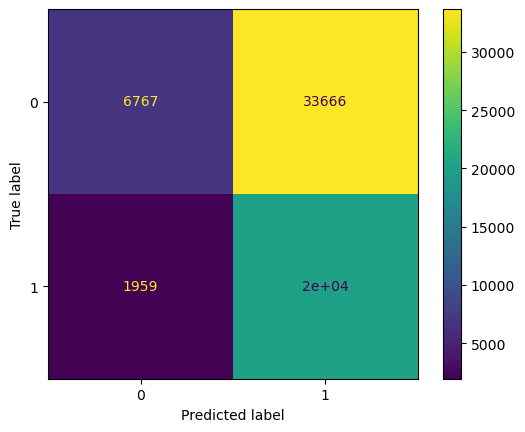

In [176]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe6, X_test_proc, y_test);

### Ensemble method - Stacking

In [108]:
# pp = ColumnTransformer(transformers=[
#     ('num', numTrans, X_num),
#     ('cat', catTrans, X_cat)
# ])

In [109]:
# estimators = [
#     ('lr', LinearRegression()),
#     ('knn', KNeighborsRegressor()),
#     ('rt', DecisionTreeRegressor())
# ]
# # linear regression makes predictions and next if fed into kneighbors and those predictions are fed into decisiontree
# sr = StackingRegressor(estimators)


# final_p = Pipeline([('preprocess', pp), ('model', sr)])


# final_p.fit(X_train, y_train)

In [177]:
estimators = [
    ('multinb', MultinomialNB()),
    ('forest', RandomForestClassifier(criterion = 'gini',
                                     max_depth = 3,
                                     min_samples_leaf = 20,
                                     n_estimators = 30)),
    ('xgb', XGBClassifier(gamma = 5,
                         learning_rate = 0.1,
                         max_depth = 3,
                         min_child_weight = 10,
                         n_estimators = 50))
]

In [178]:
sr = StackingClassifier(estimators)


In [179]:
pipe7 = Pipeline([('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                  ('ens', sr)])

In [180]:
pipe7.fit(X_train_proc, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.95, min_df=0.05)),
                ('ens',
                 StackingClassifier(estimators=[('multinb', MultinomialNB()),
                                                ('forest',
                                                 RandomForestClassifier(max_depth=3,
                                                                        min_samples_leaf=20,
                                                                        n_estimators=30)),
                                                ('xgb',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=No...
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=3,
                                                               max_leaves=None,
                                                               min_child_weight=10,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=50,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))])

In [181]:
pipe7.score(X_test, y_test)

0.6467456472732506

In [182]:
roc_auc_score(y_test, y_pred)

0.5751880189031154

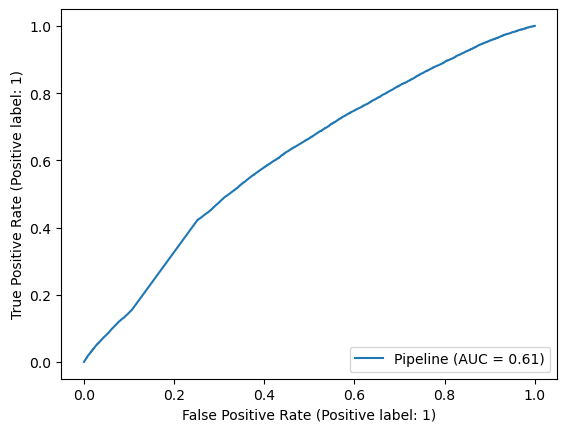

In [183]:
#plot_roc_curve(mod_pipe, X_test, y_test)
RocCurveDisplay.from_estimator(pipe7, X_test_proc, y_test)

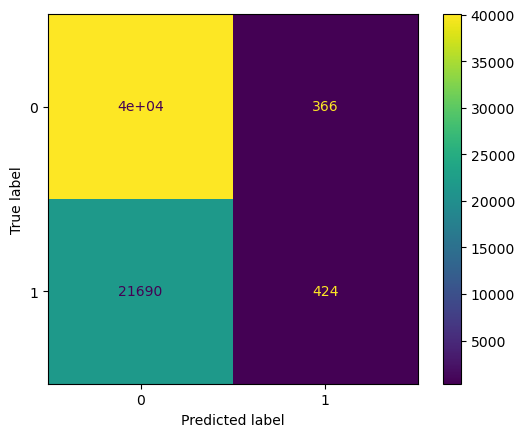

In [184]:
#plot_confusion_matrix(mod_pipe, X_test, y_test);
ConfusionMatrixDisplay.from_estimator(pipe7, X_test_proc, y_test);

In [116]:
# Neural Networks

In [117]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers, models

In [118]:
# model7 = Sequential()
# model1.add(layers.Conv2D(16, (),input_shape=(), activation = 'relu'))
# model7.add(Dense(8, activation = 'relu', input_shape = (6,)))
# model7.add(Dense(1, activation = 'sigmoid'))

In [119]:
#model7.compile(loss = 'binary_crossentropy', optimizer = 'relu', metrics = ['acc', ])

In [120]:
#history = model7.fit(X_train_proc, y_train, epochs = 10, batch_size = 5, validation_data = (val_train, val_y))

In [121]:
#history.summary()

In [122]:
# evaluating model1 train
#results_train = model7.evaluate(train_train, train_y)
#results_train

In [123]:
# evaluating model1 validation
#results_val = model7.evaluate(val_train, val_y)
#results_val

In [124]:
# evaluating model1 test
#results_test = model7.evaluate(test_train, test_y)
#results_test

In [125]:
# H5 format to save the model, so it can be used for demo